# 6. Sequence modelling

In [45]:
%config InlineBackend.figure_format = 'svg'
from IPython.display import HTML
from helper_functions import *
import matplotlib.pyplot as plt
import numpy as np
import helper_functions as h
display(HTML("""
<style>
div.text_cell_render {
font-family: "Georgia", serif;
font-size: 15px;
}
</style>
"""))

## N-gram models

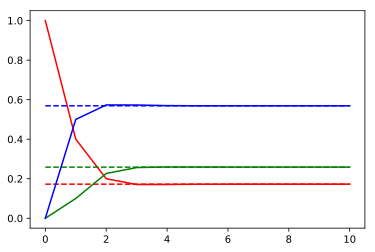

In [195]:
T_ = np.array([[0.4, 0.4, 0],
               [0.1, 0.2, 1/3],
               [0.5, 0.4, 2/3]])
probs = np.array([[1, 0, 0]])

sequence_length = 10
for n in range(sequence_length):
    
    prob_ = T_.dot(probs[-1]).reshape((1, -1))
    probs = np.append(probs, prob_, axis = 0)

colors = ['red', 'green', 'blue']
eigen_probs = np.real(np.linalg.eig(T_)[1][:, 0])
eigen_probs /= eigen_probs.sum()
for i in range(3):
    plt.plot(np.arange(sequence_length + 1), probs[:, i], color = colors[i])
    plt.plot(np.arange(sequence_length + 1), np.ones(shape = (sequence_length + 1,))*eigen_probs[i],
             '--', color = colors[i])
    
plt.show()

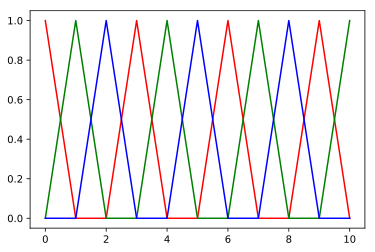

In [47]:
T_ = np.array([[0, 0, 1.0],
               [1.0, 0, 0],
               [0, 1.0, 0]])
T_ /= np.sum(T_, axis = 0)
probs = np.array([[1, 0, 0]])

sequence_length = 10
for n in range(sequence_length):
    
    prob_ = T_.dot(probs[-1]).reshape((1, -1))
    probs = np.append(probs, prob_, axis = 0)

colors = np.array(['red', 'green', 'blue'])
eigen_probs = np.real(np.linalg.eig(T_)[1][:, 0])

for i in range(3):
    plt.plot(np.arange(sequence_length + 1), probs[:, i], color = colors[i])
    
plt.show()

## Learning the N-gram parameters

Consider the problem of learning the parameters (initial probabilities $\{\pi\}$ and transition probabilities $T_{ij}$) of a bigram model, given several sampled sequences $\{\mathbf{y}_s\}$ with $\mathbf{y}_s$ being the s$^{th}$ sampled sequence. We will do this by computing the parameters which maximize the log-likelihood. Let $y_{ns}$ be the n$^{th}$ measured value of the s$^{th}$ sequence. The likelihood and log-likelihood of the model are then:

\begin{align}
p(y_{1:T}) &= p(y_1)p(y_2|y_1)p(y_3|y_2) ... p(y_N|y_{N-1}) = p(y_1)\prod_{n = 2}^N p(y_n|y_{n - 1})\\
\mathcal{L} &= \text{log}~ p(y_{1:T}) = \text{log}~p(y_1) + \sum_{n = 2}^N \text{log}~p(y_n|y_{n - 1})
\end{align}

Substituting the expressions for $p(y_1)$ and $p(y_n|p_{n-1})$

\begin{align}
p(y_1 = k) &= \pi_k = \pi_{y_{ns}}\\
p(y_{ns} = i|y_{n-1, s} = j) &= T_{ij} = T_{y_{ns}, y_{n-1, s}},\\
\end{align}

and considering the mean of the log-likelihood of the we obtain the full expression for the log-likelihood:

\begin{align}
\mathcal{L} &= \sum_{s = 1}^S\bigg[\text{log}~p(y_{1s}) + \sum_{n = 2}^N \text{log}~p(y_{ns}|y_{n - 1,s})\bigg]\\
&= \sum_{s = 1}^S\bigg[\text{log}~ \pi_{y_{ns}} + \sum_{n = 2}^N \text{log}~T_{y_{ns}, y_{n-1, s}} \bigg]\\
\end{align}

Differentiating with respect to $\pi_k$ (using Lagrange multipliers) and to $T_{ij}$:

\begin{align}
\frac{\partial \bigg[ \mathcal{L} - \lambda \big(\sum_k \pi_k - 1\big) \bigg]}{\partial \pi_k} &= \sum_{y_{1s} =~k} \frac{1}{\pi_k} - \lambda = \frac{c_k}{\pi_k} - \lambda = 0\\
\implies \pi_k = \frac{c_k}{S}\\
\frac{\partial \bigg[ \mathcal{L} - \lambda \big(\sum_a T_{ab} - 1\big) \bigg]}{\partial T_{ij}} &= \sum_{y_{ns} = i,~y_{n-1, s} = j} \frac{1}{T_{ij}} - \lambda = \frac{c_{ij}}{T_{ij}} - \lambda = 0\\
\implies T_{ij} = \frac{c_{ij}}{\sum_i c_{ij}}\\
\end{align}

In [278]:
T_ = np.array([[0.4, 0.4, 0],
               [0.1, 0.2, 1/3],
               [0.5, 0.4, 2/3]])
probs = np.array([1/3, 1/3, 1/3])
S, N, K = 10, 100, probs.shape[0]

ys = []
for n in range(S):
    y_ = [np.random.choice([0, 1, 2], p = probs)]
    
    for j in range(N - 1):
        y_.append(np.random.choice([0, 1, 2], p = T_[:, y_[-1]]))
        
    ys.append(y_)
    
ys = np.array(ys).T

In [279]:
counts = np.array([(np.where(ys[0, :] == k)[0]).shape[0] for k in range(K)])
probs_learnt = counts/counts.sum()

counts = np.array([[(np.where((ys[1:, :] == i)*(ys[:-1, :] == j))[0]).shape[0] for j in range(K)] for i in range(K)])
T_learnt = counts/np.sum(counts, axis = 0)
print(probs_learnt)
print(T_learnt)

[ 0.2  0.5  0.3]
[[ 0.40437158  0.41603053  0.        ]
 [ 0.12021858  0.22900763  0.32477064]
 [ 0.47540984  0.35496183  0.67522936]]


## Autoregressive Gaussian (AR) models

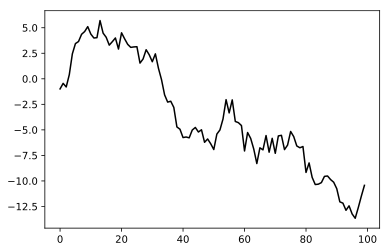

In [179]:
no_points = 10**2

lamda = 0.99
sig_noise = 1
mu_start = 0
sig_start = 1

ys = [np.random.normal(mu_start, sig_start)]

for n in range(no_points - 1):
    
    next_y = np.random.normal(lamda*ys[-1], sig_noise)
    ys.append(next_y)

ys = np.array(ys)
plt.plot(ys, color = 'black')
plt.show()

In [180]:
print('Sample mean: ', ys.mean(), '\nSample variance: ', ys.var(),
      '\nTheoretical mean: ', 0, '\nTheoretical variance: ', 1/(1 - lamda**2))

Sample mean:  -3.65858764819 
Sample variance:  28.8160054762 
Theoretical mean:  0 
Theoretical variance:  50.25125628140696


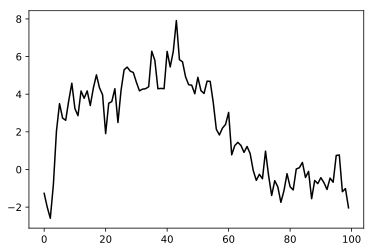

In [181]:
prec = np.eye(no_points)*(1 + lamda**2)
idx = np.arange(no_points)
prec[idx[:-1], idx[1:]] = -2*lamda
prec = 1/sig_noise**2*(prec + prec.T)/2

prec[0, 0] = 1/sig_start**2 + lamda**2/sig_noise**2
prec[-1, -1] = 1/sig_noise**2

cov = np.linalg.inv(prec)
mu = np.zeros(shape = (no_points,))

ys = np.random.multivariate_normal(mu, cov)
plt.plot(ys, color = 'black')
plt.show()

In [182]:
print('Sample mean: ', ys.mean(), '\nSample variance: ', ys.var(),
      '\nTheoretical mean: ', 0, '\nTheoretical variance: ', sig_noise**2/(1 - lamda**2))

Sample mean:  2.22663206603 
Sample variance:  6.40727426196 
Theoretical mean:  0 
Theoretical variance:  50.25125628140696


## Learning the AR parameters

Consider the problem of learning the parameters ($\mu_0, \sigma_0, \lambda, \sigma$) of an AR model, given several sampled sequences $\{\mathbf{y}_s\}$ with $\mathbf{y}_s$ being the s$^{th}$ sampled sequence. We will do this by computing the ($\mu_0, \sigma_0, \lambda, \sigma$) which maximize the log-likelihood. Let $y_{ns}$ be the n$^{th}$ measured value of the s$^{th}$ sequence. The likelihood and log-likelihood of the model are then:

\begin{align}
p(y_{1:T}) &= p(y_1)p(y_2|y_1)p(y_3|y_2) ... p(y_N|y_{N-1}) = p(y_1)\prod_{n = 2}^N p(y_n|y_{n - 1})\\
\mathcal{L} &= \text{log}~ p(y_{1:T}) = \text{log}~p(y_1) + \sum_{n = 2}^N \text{log}~p(y_n|y_{n - 1})
\end{align}

Substituting the expressions for $p(y_1)$ and $p(y_n|p_{n-1})$

\begin{align}
p(y_1) &= \mathcal{N}(\mu_0, \sigma_0^2)\\
p(y_n|y_{n-1}) &= \mathcal{N}(\lambda y_{n-1}, \sigma^2),\\
\end{align}

and considering the mean of the log-likelihood of the we obtain the full expression for the log-likelihood:

\begin{align}
\mathcal{L} &= \sum_{s = 1}^S\bigg[\text{log}~p(y_{1s}) + \sum_{n = 2}^N \text{log}~p(y_{ns}|y_{n - 1,s})\bigg]\\
&= \sum_{s = 1}^S\bigg[-\frac{1}{2\sigma^2_0}(y_{1s} - \mu_0)^2 - \frac{1}{2}\text{log}(\sigma^2_0) + \sum_{n = 2}^N -\frac{1}{2\sigma^2}(y_{ns} - \lambda y_{n - 1,s})^2  - \frac{1}{2}\text{log}(\sigma^2) \bigg] + \text{const.}\\
\end{align}

Differentiating with respect to the parameters:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \mu_0} &= \sum_{s = 1}^S\bigg[\frac{1}{\sigma^2_0}(y_{1s} - \mu_0)\bigg]\\
\frac{\partial \mathcal{L}}{\partial \mu_0} &= 0 \implies \mu_0 = \frac{\sum_{s = 1}^S y_{1s}}{S}\\
\frac{\partial \mathcal{L}}{\partial \sigma_0^2} &= \sum_{s = 1}^S\bigg[\frac{1}{2\sigma^4_0}(y_{1s} - \mu_0)^2 - \frac{1}{2\sigma^2_0}\bigg]\\
\frac{\partial \mathcal{L}}{\partial \sigma_0^2} &= 0 \implies \sigma_0^2 = \frac{\sum_{s = 1}^S (y_{1s} - \mu_0)^2}{S}\\
\frac{\partial \mathcal{L}}{\partial \lambda} &=  \sum_{s = 1}^S\sum_{n = 2}^N\bigg[\frac{1}{\sigma^2}(y_{ns} - \lambda y_{n - 1,s})y_{n - 1,s} \bigg]\\
\frac{\partial \mathcal{L}}{\partial \lambda} &= 0 \implies \lambda = \frac{\sum_{s = 1}^S\sum_{n = 2}^N  y_{ns}y_{n - 1,s}}{ \sum_{s = 1}^S\sum_{n = 2}^N y_{n - 1,s}^2}\\
\frac{\partial \mathcal{L}}{\partial \sigma^2} &= \sum_{s = 1}^S\bigg[\sum_{n = 2}^N \frac{1}{2\sigma^4}(y_{ns} - \lambda y_{n - 1,s})^2 - \frac{1}{2\sigma^2}\bigg]\\
\frac{\partial \mathcal{L}}{\partial \sigma^2} &= 0 \implies \sigma_0^2 = \frac{\sum_{s = 1}^S \sum_{n = 2}^N (y_{ns} - \lambda y_{n - 1,s})^2}{S(N-1)}\\
\end{align}

In [194]:
cov = np.linalg.inv(prec)
mu = np.zeros(shape = (no_points,))

S = 10
ys = np.random.multivariate_normal(mu, cov, S).T

mu_0_learnt = ys[0, :].mean()
sig_0_learnt = np.mean((ys[0, :] - mu_0)**2)

lamda_learnt = np.sum(ys[1:, :]*ys[:-1, :])/np.sum(ys[:-1, :]*ys[:-1, :])
sigma_learnt = np.sum((ys[1:, :] - lamda*ys[:-1, :])**2)/(S*(mu.shape[0] - 1))

print(r'mu_0, true: {}, learnt: {:3f}'.format(mu_start, mu_0_learnt))
print(r'sigma_0, true: {}, learnt: {:3f}'.format(sig_start, sig_0_learnt))
print(r'lamda, true: {}, learnt: {:3f}'.format(lamda, lamda_learnt))
print(r'sigma_0, true: {}, learnt: {:3f}'.format(sig_noise, sigma_learnt))

mu_0, true: 0, learnt: -0.223415
sigma_0, true: 1, learnt: 2.419228
lamda, true: 0.99, learnt: 0.986384
sigma_0, true: 1, learnt: 0.963197


## Hidden Markov Models (discrete and continuous latent variables)

In [65]:
T_ = np.array([[0.4, 0.4, 0],
               [0.1, 0.2, 1/3],
               [0.5, 0.4, 2/3]])
T_ /= np.sum(T_, axis = 0)
state = np.array([[1, 0, 0]]).T

means = [-1, 0, 1]
sig_noise = 0.5

no_points = 100
xs = []
ys = []
for n in range(no_points):
    state_ = np.dot(T_, state)
    state = state_
    x_ = np.random.choice([0, 1, 2], p = state_[:, 0])
    y_ = np.random.normal(x_, sig_noise)
    
    xs.append(x_)
    ys.append(y_)

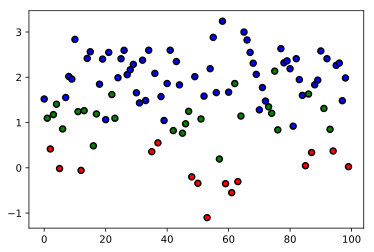

In [67]:
plt.scatter(np.arange(len(ys)), ys, color = colors[xs],
            marker='o', linewidth=1.5, edgecolor='black')
plt.show()

In [81]:
sig_noise = 1
sig_trans = 1
lamda = 0.99
coeff = 1

no_points = 100
xs = [np.random.normal(0, sig_trans)]
ys = [np.random.normal(coeff*xs[-1], sig_noise)]

for n in range(no_points):
    x_ = np.random.normal(lamda*xs[-1], sig_trans)
    y_ = np.random.normal(coeff*xs[-1], sig_noise)
    
    xs.append(x_)
    ys.append(y_)

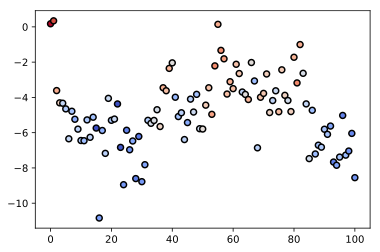

In [87]:
plt.scatter(np.arange(len(ys)), ys, c = xs, cmap = 'coolwarm',
            marker='o', linewidth=1.5, edgecolor='black')
plt.show()